# Loan Default Prediction using Machine Learning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing necessary libraries:

In [ ]:
import pandas as pd
import numpy as np
from IPython import display
import tensorflow as tf
import torch.utils.data as torchdata
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score,recall_score

Loading the dataset into pandas dataframe

In [ ]:
accepted_path = '/content/drive/MyDrive/Data/LendingClubDataset/accepted_2007_to_2018Q4.csv'
data=pd.read_csv(accepted_path)
accepted=data[:][:200000]
accepted.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
len(data)

2260701

Transforming target 'loan_status' column. Keeping only the rows with loan_status as 'Charged Off' or 'Fully Paid':

In [ ]:
accepted = accepted[(accepted["loan_status"] == "Fully Paid") |
(accepted["loan_status"] == "Charged Off")]
mapping_dictionary = {"loan_status":{ "Fully Paid": 0, "Charged Off": 1}}
accepted = accepted.replace(mapping_dictionary)

Removing columns with more than 5% missing values:

In [ ]:
percent_missing = accepted.isnull().sum() * 100 / len(accepted)
missing_value_df = pd.DataFrame({'column_name': accepted.columns,
                                 'percent_missing': percent_missing})
missing_col=missing_value_df[missing*_value_df['percent_missing']>10]['column_name']
missing_col_arr=np.array(missing_col)
accepted=accepted.drop(missing_col_arr,axis=1)

Removing fields unrelated to the 'loan_status' classification:

In [ ]:
accepted=accepted.drop(['id', 'zip_code','issue_d','url'],axis=1)

Removing features that leak information from the future:

In [ ]:
accepted=accepted.drop(['funded_amnt','funded_amnt_inv','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d','last_pymnt_amnt','last_fico_range_low','last_fico_range_high','disbursement_method','last_credit_pull_d','acc_now_delinq','bc_util',
 'num_op_rev_tl', 'num_rev_accts', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'percent_bc_gt_75',
       'total_bal_ex_mort', 'total_il_high_credit_limit','hardship_flag', 'debt_settlement_flag'],axis=1)

**Processing categorical features:**

In [ ]:
accepted.dtypes

loan_amnt                     float64
term                           object
int_rate                      float64
installment                   float64
grade                          object
sub_grade                      object
emp_title                      object
emp_length                     object
home_ownership                 object
annual_inc                    float64
verification_status            object
loan_status                     int64
pymnt_plan                     object
purpose                        object
title                          object
addr_state                     object
dti                           float64
delinq_2yrs                   float64
earliest_cr_line               object
fico_range_low                float64
fico_range_high               float64
inq_last_6mths                float64
open_acc                      float64
pub_rec                       float64
revol_bal                     float64
revol_util                    float64
total_acc   

Plotting histogram of 'term' field:

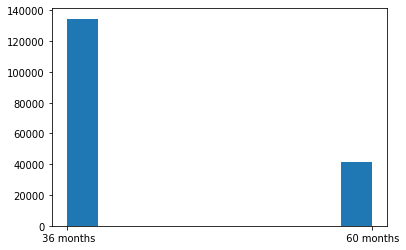

Null Values: 0


In [ ]:
plt.hist(accepted['term'])
plt.show()
print("Null Values:",accepted['term'].isnull().sum())

As seen above, 'term' is a nominal categorical field and can be easily transformed using one-hot encoding.

Plotting histogram of 'grade':

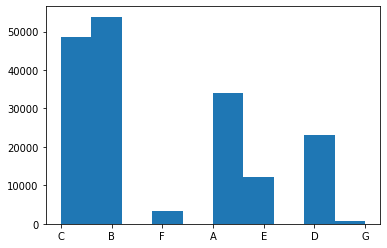

Null Values: 0


In [ ]:
plt.hist(accepted['grade'])
plt.show()
print("Null Values:",accepted['grade'].isnull().sum())

'grade' is an ordinal categorical feature and can be beneficial for classification as seen in the data dictionary description of the field.

Plotting 'sub_grade':

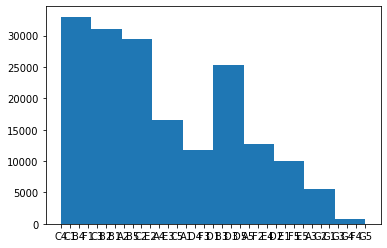

In [ ]:
plt.hist(accepted['sub_grade'])
plt.show()
accepted=accepted.drop('sub_grade',axis=1)

'sub_grade' have a lot of unique values and is basically a sub-child of the 'grade' column. I will keep the 'grade' field which is a broader classfication and will remove 'sub_grade' field.

Printing number of unique values in 'emp_title'

In [ ]:
print(len(accepted['emp_title'].unique()))
accepted=accepted.drop('emp_title',axis=1)

59467


'emp_title' is a nominal field and can be useful for loan status classification but encoding a nominal feature with such a large number of unique values will result in an unusually large number of features which will confuse our classifier.

Printing the number of unique 'emp_length' values:

In [ ]:
len(accepted['emp_length'].unique())

12

'emp_length' is an ordinal feature and can be useful for classification

plotting hist of 'home_ownership':

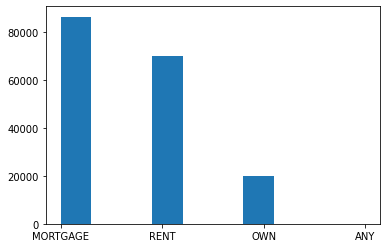

Null Values: 0


In [ ]:
plt.hist(accepted['home_ownership'])
plt.show()
print("Null Values:",accepted['home_ownership'].isnull().sum())

'home_ownership' is a nominal field and can be useful for classification

Plotting histogram of 'verification_status':

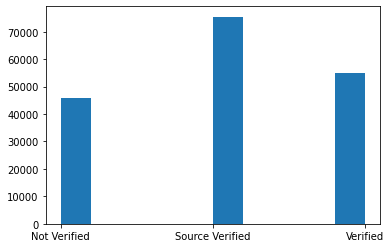

Null Values: 0


In [ ]:
plt.hist(accepted['verification_status'])
plt.show()
print("Null Values:",accepted['verification_status'].isnull().sum())

Plotting histogram of 'pymnt_plan':

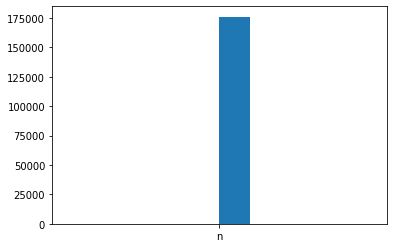

In [ ]:
plt.hist(accepted['pymnt_plan'])
plt.show()
accepted=accepted.drop('pymnt_plan',axis=1)

Removing 'pymnt_plan' column as it has only one unique value.

Plotting histogram of 'purpose' column:

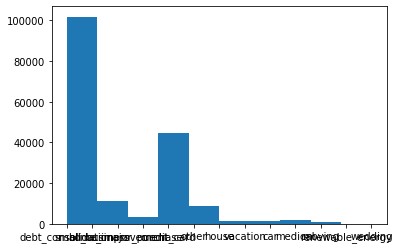

Null Values: 0


In [ ]:
plt.hist(accepted['purpose'])
plt.show()
accepted['purpose'].unique()
print("Null Values:",accepted['purpose'].isnull().sum())

Printing unique values in the 'title' column:

In [ ]:
accepted['title'].unique()
print("Null Values:",accepted['title'].isnull().sum())

Null Values: 118


Removing 'title' column as it has almost the same values as the 'purpose' column and seems to be a sub classification of the 'purpose' field.

In [ ]:
accepted=accepted.drop('title',axis=1)

Plotting histogram of 'addr_state' column:



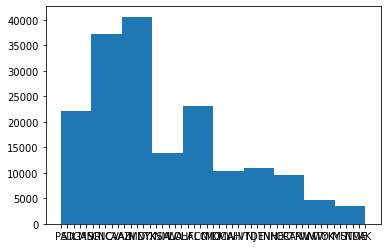

In [ ]:
plt.hist(accepted['addr_state'])
plt.show()
accepted=accepted.drop('addr_state',axis=1)

'earliest_cr_line' is a date column. The following code will replace the date with the number of days from today.

In [ ]:
print(accepted['earliest_cr_line'])
from datetime import date
cr_line=[]
for index, row in accepted.iterrows():
    d=row['earliest_cr_line'].split('-')
    today = date.today().year
    cr_line=cr_line+[today-int(d[1])]
accepted['earliest_cr_line']=cr_line
print(accepted['earliest_cr_line'])

0         Aug-2003
1         Dec-1999
2         Aug-2000
4         Jun-1998
5         Oct-1987
            ...   
199995    Sep-2003
199996    Oct-2001
199997    Jun-2002
199998    Nov-1990
199999    Mar-2005
Name: earliest_cr_line, Length: 176082, dtype: object
0         19
1         23
2         22
4         24
5         35
          ..
199995    19
199996    21
199997    20
199998    32
199999    17
Name: earliest_cr_line, Length: 176082, dtype: int64


Plotting histogram of 'initial_list_status' column:

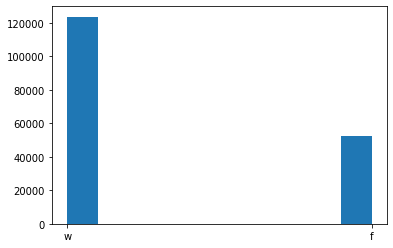

In [ ]:
plt.hist(accepted['initial_list_status'])
plt.show()

Plotting histogram of 'application_type' column:

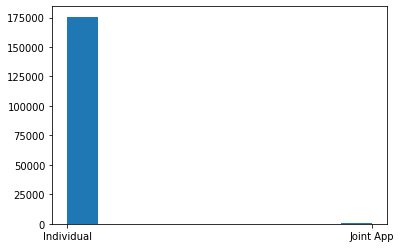

In [ ]:
plt.hist(accepted['application_type'])
plt.show()
accepted=accepted.drop('application_type',axis=1)

Removing 'application_type' column as almost all the rows have the same value.

**Encoding Ordinal Features**

In [ ]:
mapping_dict={
    "grade":{
'A': 1,
'B': 2,
'C': 3,
'D': 4,
'E': 5,
'F': 6,
'G': 7
}
}
accepted = accepted.replace(mapping_dict)

In [ ]:
mapping_dictionary = {"emp_length":{ "< 1 year": 0, "1 year": 1, "2 years": 2, "3 years": 3, "4 years": 4, "5 years": 5, "6 years": 6, "7 years": 7, "8 years": 8, "9 years": 9, "10 years": 10, "10+ years": 10}}
accepted = accepted.replace(mapping_dictionary)

**Removing fields with low correlation with target column**

In [ ]:
corr_df=accepted.corr()

In [ ]:
rm_col=[]
for index, row in corr_df.iterrows():
    if abs(row['loan_status'])<0.02:
        rm_col.append(index)
        
accepted=accepted.drop(rm_col,axis=1)

**Removing fields variance lower than 1**

In [ ]:
test=accepted.drop('loan_status',axis=1)
test.var()<1
accepted=accepted.drop(['inq_last_6mths','pub_rec','policy_code','pub_rec_bankruptcies'],axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


**Removing features with high correlation among them**

In [ ]:
corr_df

,loan_amnt,int_rate,installment,grade,emp_length,annual_inc,loan_status,dti,delinq_2yrs,earliest_cr_line,...,num_il_tl,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bc_limit
loan_amnt,1.000000,0.126362,0.954794,0.123619,0.078771,0.283096,0.066721,0.013943,-0.017553,0.158564,...,0.077000,0.168320,0.194392,-0.036197,-0.022273,0.108698,-0.113125,-0.000109,0.343293,0.396757
int_rate,0.126362,1.000000,0.102986,0.970542,-0.020698,-0.088346,0.308937,0.189858,0.043968,-0.157894,...,0.042056,0.045848,-0.020052,0.031314,0.277870,-0.058287,0.073963,0.012398,-0.125707,-0.268438
installment,0.954794,0.102986,1.000000,0.097590,0.067105,0.278429,0.033792,0.002784,-0.007929,0.145933,...,0.057318,0.164493,0.175441,-0.029522,-0.007659,0.089786,-0.108618,0.008227,0.318101,0.368598
grade,0.123619,0.970542,0.097590,1.000000,-0.019600,-0.085107,0.303626,0.183267,0.043013,-0.150406,...,0.041341,0.044596,-0.018665,0.032100,0.270366,-0.059191,0.076689,0.012711,-0.120292,-0.257777
emp_length,0.078771,-0.020698,0.067105,-0.019600,1.000000,0.055289,-0.011979,0.038878,0.019281,0.211427,...,-0.052867,0.124943,0.037812,-0.000096,0.024857,-0.024404,0.015940,0.012648,0.116254,0.062905
annual_inc,0.283096,-0.088346,0.278429,-0.085107,0.055289,1.000000,-0.040605,-0.155478,0.034695,0.119647,...,0.079263,0.075099,0.117666,0.002045,0.043866,-0.003309,-0.047328,0.034150,0.376068,0.244823
loan_status,0.066721,0.308937,0.033792,0.303626,-0.011979,-0.040605,1.000000,0.114731,0.017488,-0.044482,...,0.028356,0.076582,0.042524,0.010214,0.114124,-0.003712,0.033782,0.007485,-0.075054,-0.077523
dti,0.013943,0.189858,0.002784,0.183267,0.038878,-0.155478,0.114731,1.000000,-0.013157,0.035666,...,0.214518,0.244823,0.272092,-0.015453,0.085706,0.100037,-0.036079,-0.031683,0.009676,0.033725
delinq_2yrs,-0.017553,0.043968,-0.007929,0.043013,0.019281,0.034695,0.017488,-0.013157,1.000000,0.079737,...,0.083155,-0.013506,0.039211,0.646252,-0.015684,-0.450007,-0.041680,0.006831,0.053765,-0.083822
earliest_cr_line,0.158564,-0.157894,0.145933,-0.150406,0.211427,0.119647,-0.044482,0.035666,0.079737,1.000000,...,-0.005030,0.156546,0.128221,0.038736,-0.013031,-0.101439,0.059835,0.033091,0.205531,0.250312


**Handling Missing Values**

Printing number of null values in each column:

In [ ]:
accepted.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
home_ownership              0
annual_inc                  0
verification_status         0
loan_status                 0
purpose                     0
dti                         2
earliest_cr_line            0
fico_range_low              0
fico_range_high             0
open_acc                    0
revol_bal                   0
revol_util                 69
initial_list_status         0
tot_cur_bal                 0
total_rev_hi_lim            0
acc_open_past_24mths        0
avg_cur_bal                 0
bc_open_to_buy           1675
mo_sin_old_il_acct       5260
mo_sin_old_rev_tl_op        0
mo_sin_rcnt_rev_tl_op       0
mo_sin_rcnt_tl              0
mort_acc                    0
mths_since_recent_bc     1616
num_actv_bc_tl              0
num_actv_rev_tl             0
num_il_tl                   0
num_rev_tl_bal_gt_0         0
num_sats  

Replacing certain missing values and dropping the rest.

In [ ]:
accepted['revol_util']=accepted['revol_util'].fillna(accepted['revol_util'].mean())
accepted['bc_open_to_buy']=accepted['bc_open_to_buy'].fillna(0)
accepted['dti']=accepted['dti'].fillna(accepted['dti'].mean())
accepted=accepted.dropna()

**One-hot encoding nominal features**

In [ ]:
accepted.dtypes

loan_amnt                float64
term                      object
int_rate                 float64
installment              float64
grade                      int64
home_ownership            object
annual_inc               float64
verification_status       object
loan_status                int64
purpose                   object
dti                      float64
earliest_cr_line           int64
fico_range_low           float64
fico_range_high          float64
open_acc                 float64
revol_bal                float64
revol_util               float64
initial_list_status       object
tot_cur_bal              float64
total_rev_hi_lim         float64
acc_open_past_24mths     float64
avg_cur_bal              float64
bc_open_to_buy           float64
mo_sin_old_il_acct       float64
mo_sin_old_rev_tl_op     float64
mo_sin_rcnt_rev_tl_op    float64
mo_sin_rcnt_tl           float64
mort_acc                 float64
mths_since_recent_bc     float64
num_actv_bc_tl           float64
num_actv_r

In [ ]:
nominal_columns = ["home_ownership", "verification_status", "purpose", "term", 'initial_list_status']
dummy_df = pd.get_dummies(accepted[nominal_columns])
processed_data = pd.concat([accepted, dummy_df], axis=1)
processed_data=processed_data.drop(nominal_columns,axis=1)

In [ ]:
y=np.array(processed_data['loan_status'])
processed_data_x=processed_data.drop("loan_status",axis=1)
X=np.array(processed_data_x)

Using average of fico high and low values:

In [ ]:
processed_data_x['fico']=(processed_data_x['fico_range_low']+processed_data_x['fico_range_high'])/2
processed_data_x=processed_data_x.drop(['fico_range_low', 'fico_range_high'], axis=1)

Scaling the features:

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit_transform(X)

array([[0.07647059, 0.36628644, 0.07566978, ..., 0.        , 0.        ,
        1.        ],
       [0.69705882, 0.2817913 , 0.56302204, ..., 0.        , 0.        ,
        1.        ],
       [0.55882353, 0.23067174, 0.29208983, ..., 1.        , 0.        ,
        1.        ],
       ...,
       [0.77941176, 0.39416984, 0.44343638, ..., 1.        , 1.        ,
        0.        ],
       [0.17647059, 0.23954373, 0.14983679, ..., 0.        , 0.        ,
        1.        ],
       [0.64705882, 0.36628644, 0.36366369, ..., 1.        , 0.        ,
        1.        ]])

Splitting the dataset into train and test:

In [ ]:
from sklearn.model_selection import train_test_split
X_t, X_test, y_t, y_test = train_test_split(X,y,test_size=0.3, shuffle=True, random_state=1)

Splitting the training dataset into train and validation set:

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_t,y_t,test_size=0.3, shuffle=True, random_state=1)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((82922, 55), (35539, 55), (82922,), (35539,))

Function to visualize heatmap of confusion matrix:

In [ ]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds)
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=2)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() 

Fitting various supervised classifiers to the dataset and testing the accuracy on validation set:

Default Rate: 0.21843868864336172
Training Accuracy 1.0
Validation  Accuracy 0.8073102788485889
              precision    recall  f1-score   support

           0       0.82      0.97      0.89     28423
           1       0.57      0.15      0.24      7116

    accuracy                           0.81     35539
   macro avg       0.70      0.56      0.57     35539
weighted avg       0.77      0.81      0.76     35539

(0.6955503064909627, 0.5619171592205656, 0.5652249211970292, None)


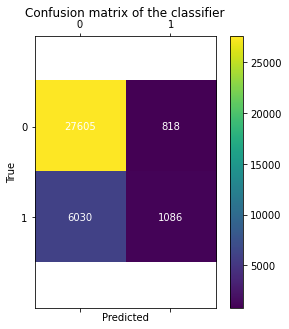

None


In [ ]:
rf = RandomForestClassifier(n_estimators= 100).fit(X_train, y_train)
train_preds=rf.predict(X_train)
val_preds_rf=rf.predict(X_val)
cm=confusion_matrix(y_val,val_preds_rf)
default_rate_rf=cm[1][0]/cm[0][0]
print("Default Rate:",default_rate_rf)
print('Training Accuracy', np.mean(train_preds==y_train))
print('Validation  Accuracy', np.mean(val_preds_rf==y_val))
print(classification_report(y_val, val_preds_rf))
print(precision_recall_fscore_support(y_val, val_preds_rf, average='macro'))
print(confusion_matrix_heatmap(y_val, val_preds_rf))

Default Rate: 0.23580161276337466
Training Accuracy 1.0
Validation  Accuracy 0.6962210529277695
              precision    recall  f1-score   support

           0       0.81      0.81      0.81     28423
           1       0.24      0.24      0.24      7116

    accuracy                           0.70     35539
   macro avg       0.52      0.52      0.52     35539
weighted avg       0.69      0.70      0.70     35539

(0.5238023952319795, 0.5235959907418872, 0.523694372111223, None)


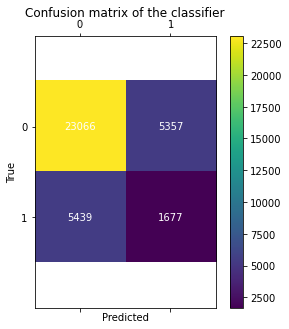

None


In [ ]:
knn = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
train_preds=knn.predict(X_train)
val_preds_knn=knn.predict(X_val)
cm=confusion_matrix(y_val,val_preds_knn)
default_rate_knn=cm[1][0]/cm[0][0]
print("Default Rate:",default_rate_knn)
print('Training Accuracy', np.mean(train_preds==y_train))
print('Validation  Accuracy', np.mean(val_preds_knn==y_val))
print(classification_report(y_val, val_preds_knn))
print(precision_recall_fscore_support(y_val, val_preds_knn, average='macro'))
print(confusion_matrix_heatmap(y_val, val_preds_knn))

Default Rate: 0.20724959700257048
Training Accuracy 1.0
Validation  Accuracy 0.7122316328540477
              precision    recall  f1-score   support

           0       0.83      0.81      0.82     28423
           1       0.30      0.33      0.32      7116

    accuracy                           0.71     35539
   macro avg       0.56      0.57      0.57     35539
weighted avg       0.72      0.71      0.72     35539

(0.5648223722339272, 0.569528343858204, 0.566749286603567, None)


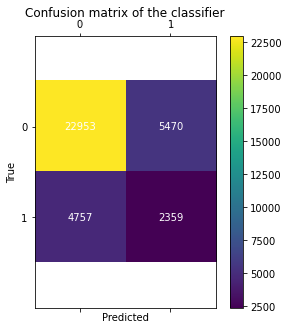

None


In [ ]:
dt=DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
train_preds=dt.predict(X_train)
val_preds_dt=dt.predict(X_val)
cm=confusion_matrix(y_val,val_preds_dt)
default_rate_dt=cm[1][0]/cm[0][0]
print("Default Rate:",default_rate_dt)
print('Training Accuracy', np.mean(train_preds==y_train))
print('Validation  Accuracy', np.mean(val_preds_dt==y_val))
print(classification_report(y_val, val_preds_dt))
print(precision_recall_fscore_support(y_val, val_preds_dt, average='macro'))
print(confusion_matrix_heatmap(y_val, val_preds_dt))

Default Rate: 0.14985862393967955
Training Accuracy 0.5353585297026121
Validation  Accuracy 0.5301781141844171
              precision    recall  f1-score   support

           0       0.87      0.49      0.62     28423
           1       0.26      0.71      0.38      7116

    accuracy                           0.53     35539
   macro avg       0.56      0.60      0.50     35539
weighted avg       0.75      0.53      0.57     35539

(0.5631200230919371, 0.5974019167433162, 0.4999046064124443, None)


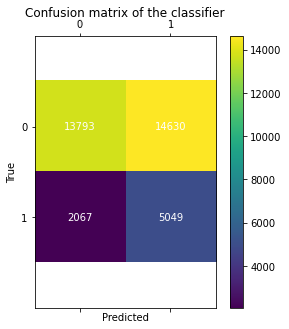

None


In [ ]:
gnb=GaussianNB().fit(X_train, y_train)
train_preds=gnb.predict(X_train)
val_preds_gnb=gnb.predict(X_val)
cm=confusion_matrix(y_val,val_preds_gnb)
default_rate_gnb=cm[1][0]/cm[0][0]
print("Default Rate:",default_rate_gnb)
print('Training Accuracy', np.mean(train_preds==y_train))
print('Validation  Accuracy', np.mean(val_preds_gnb==y_val))
print(classification_report(y_val, val_preds_gnb))
print(precision_recall_fscore_support(y_val, val_preds_gnb, average='macro'))
print(confusion_matrix_heatmap(y_val, val_preds_gnb))

Default Rate: 0.21706380821322518
Training Accuracy 0.8127276235498421
Validation  Accuracy 0.8085764934297532
              precision    recall  f1-score   support

           0       0.82      0.97      0.89     28423
           1       0.58      0.16      0.25      7116

    accuracy                           0.81     35539
   macro avg       0.70      0.56      0.57     35539
weighted avg       0.77      0.81      0.76     35539

(0.7013478486725622, 0.5646049926670911, 0.5691835263440601, None)


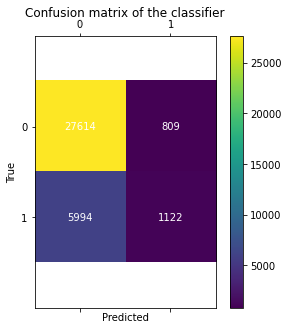

None


In [ ]:
xgbclf=xgb.XGBClassifier(objective="binary:logistic", random_state=42).fit(X_train, y_train)
train_preds=xgbclf.predict(X_train)
val_preds_xgb=xgbclf.predict(X_val)
cm=confusion_matrix(y_val,val_preds_xgb)
default_rate_xgb=cm[1][0]/cm[0][0]
print("Default Rate:",default_rate_xgb)
print('Training Accuracy', np.mean(train_preds==y_train))
print('Validation  Accuracy', np.mean(val_preds_xgb==y_val))
print(classification_report(y_val, val_preds_xgb))
print(precision_recall_fscore_support(y_val, val_preds_xgb, average='macro'))
print(confusion_matrix_heatmap(y_val, val_preds_xgb))

Default Rate: 0.21688759760305065
Training Accuracy 0.8097368611466197
Validation  Accuracy 0.806972621626945
              precision    recall  f1-score   support

           0       0.82      0.97      0.89     28423
           1       0.56      0.16      0.25      7116

    accuracy                           0.81     35539
   macro avg       0.69      0.56      0.57     35539
weighted avg       0.77      0.81      0.76     35539

(0.6923803558264592, 0.5647610853278793, 0.569669544532097, None)


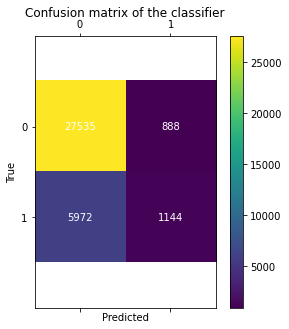

None


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(n_estimators=100).fit(X_train,y_train)
train_preds=clf.predict(X_train)
val_preds_ada=clf.predict(X_val)
cm=confusion_matrix(y_val,val_preds_ada)
default_rate_ada=cm[1][0]/cm[0][0]
print("Default Rate:",default_rate_ada)
print('Training Accuracy', np.mean(train_preds==y_train))
print('Validation  Accuracy', np.mean(val_preds_ada==y_val))
print(classification_report(y_val, val_preds_ada))
print(precision_recall_fscore_support(y_val, val_preds_ada, average='macro'))
print(confusion_matrix_heatmap(y_val, val_preds_ada))

Fitting various unsupervised classifiers to the dataset and testing the accuracy on validation set:

In [ ]:
!pip install mixture

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Initialization 0
Initialization converged: True	 time lapse 2.12514s	 ll -137.48494
Default Rate: 0.25096626515066234
Training Accuracy 0.7639106630327296
Validation  Accuracy 0.761895382537494
              precision    recall  f1-score   support

           0       0.80      0.94      0.86     28423
           1       0.19      0.06      0.09      7116

    accuracy                           0.76     35539
   macro avg       0.50      0.50      0.48     35539
weighted avg       0.68      0.76      0.71     35539

(0.4968754118245903, 0.49886595376754017, 0.4774254792106647, None)


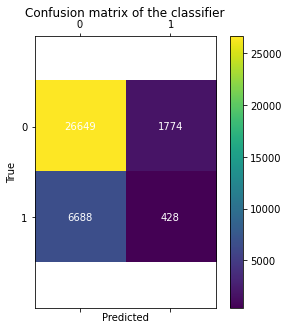

None


In [ ]:
from sklearn import mixture
n=2                # number of mixtures/clusters
init = 'kmeans'    # initialisation as in k-means 

gmm1 = mixture.GaussianMixture(n_components=n,covariance_type='diag', max_iter=100, init_params=init, verbose=2)
gmm1.fit(X_train)

train_preds=gmm1.predict(X_train)
val_preds_gmm=gmm1.predict(X_val)

if np.sum(val_preds_gmm)>7116:
  train_preds=1-train_preds
  val_preds_gmm=1-val_preds_gmm

cm=confusion_matrix(y_val,val_preds_gmm)
default_rate_gmm=cm[1][0]/cm[0][0]
print("Default Rate:",default_rate_gmm)
print('Training Accuracy', np.mean(train_preds==y_train))
print('Validation  Accuracy', np.mean(val_preds_gmm==y_val))
print(classification_report(y_val, val_preds_gmm))
print(precision_recall_fscore_support(y_val, val_preds_gmm, average='macro'))
print(confusion_matrix_heatmap(y_val, val_preds_gmm))

**Test the final model on test dataset**

Default Rate: 0.14130050950915604
Test  Accuracy 0.5327069668498493
              precision    recall  f1-score   support

           0       0.88      0.49      0.63     40746
           1       0.26      0.72      0.38     10023

    accuracy                           0.53     50769
   macro avg       0.57      0.60      0.50     50769
weighted avg       0.75      0.53      0.58     50769

(0.5663965871008465, 0.603522247086744, 0.5020297314660165, None)


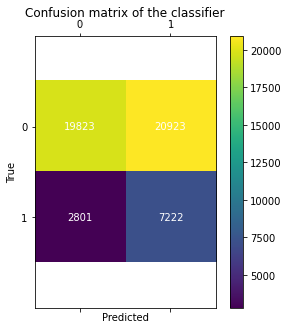

None


In [ ]:
test_preds=gnb.predict(X_test)
cm=confusion_matrix(y_test,test_preds)
default_rate_test=cm[1][0]/cm[0][0]
print("Default Rate:",default_rate_test)
print('Test  Accuracy', np.mean(test_preds==y_test))
print(classification_report(y_test, test_preds))
print(precision_recall_fscore_support(y_test, test_preds, average='macro'))
print(confusion_matrix_heatmap(y_test, test_preds))

**Ploting performances**

In [ ]:
models=['Random Forest', 'k-Nearest Neighbours', 'Decision Tree', 'Gaussian Naive Bayes', 'XGBoost', 'Adaboost']
accuracies=[np.mean(y_val==val_preds_rf), np.mean(y_val==val_preds_knn),np.mean(y_val==val_preds_dt), np.mean(y_val==val_preds_gnb),np.mean(y_val==val_preds_xgb),np.mean(y_val==val_preds_ada)]
precision=[precision_score(y_val,val_preds_rf),precision_score(y_val,val_preds_knn),precision_score(y_val,val_preds_dt), precision_score(y_val,val_preds_gnb), precision_score(y_val,val_preds_xgb), precision_score(y_val,val_preds_ada)]
recall=[recall_score(y_val,val_preds_rf),recall_score(y_val,val_preds_knn),recall_score(y_val,val_preds_dt), recall_score(y_val,val_preds_gnb), recall_score(y_val,val_preds_xgb), recall_score(y_val,val_preds_ada)]
defaults=[default_rate_rf, default_rate_knn, default_rate_dt, default_rate_gnb, default_rate_xgb, default_rate_ada]
test_performance=[np.mean(y_test==test_preds),precision_score(y_test,test_preds),recall_score(y_test,test_preds),default_rate_test]
test_labels=['Accuracy', 'Precision', 'Recall', 'Default Rate']

([<matplotlib.axis.XTick at 0x7fbb51411f50>,
 [Text(0, 0, 'Random Forest'),
  Text(0, 0, 'k-Nearest Neighbours'),
  Text(0, 0, 'Decision Tree'),
  Text(0, 0, 'Gaussian Naive Bayes'),
  Text(0, 0, 'XGBoost'),
  Text(0, 0, 'Adaboost')])

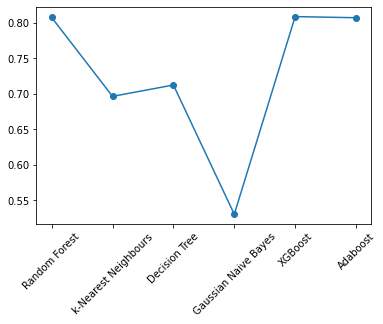

In [ ]:
ind=[0,1,2,3,4,5]
plt.plot(ind,accuracies)
plt.scatter(ind,accuracies)
plt.xticks(ticks=ind,labels=models,rotation=45)
plt.title('Comparison of accuracies of various models')
plt.show()

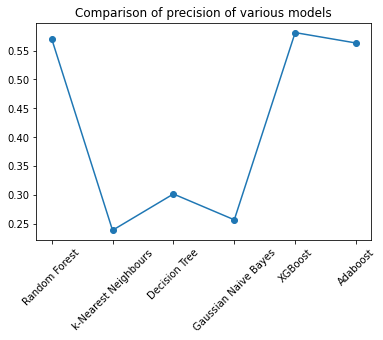

In [ ]:
ind=[0,1,2,3,4,5]
plt.plot(ind,precision)
plt.scatter(ind,precision)
plt.xticks(ticks=ind,labels=models,rotation=45)
plt.title('Comparison of precision of various models')
plt.show()

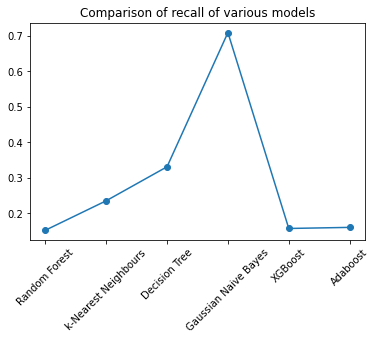

In [ ]:
ind=[0,1,2,3,4,5]
plt.plot(ind,recall)
plt.scatter(ind,recall)
plt.xticks(ticks=ind,labels=models,rotation=45)
plt.title('Comparison of recall of various models')
plt.show()

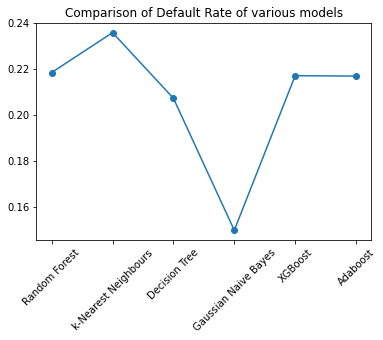

In [ ]:
ind=[0,1,2,3,4,5]
plt.plot(ind,defaults)
plt.scatter(ind,defaults)
plt.xticks(ticks=ind,labels=models,rotation=45)
plt.title('Comparison of Default Rate of various models')
plt.show()

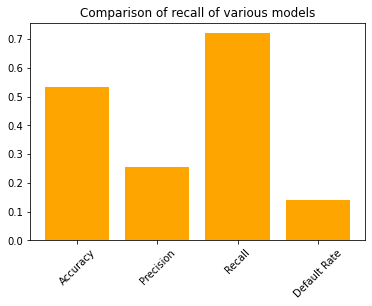

In [ ]:
ind=[0,1,2,3]
plt.bar(ind, test_performance, color='orange')
# plt.scatter(ind,recall)
plt.xticks(ticks=ind,labels=test_labels,rotation=45)
plt.title('Comparison of recall of various models')
plt.show()